In [72]:
import requests
import json
import pandas as pd
import os
from pathlib import Path
import panel as pn
from panel.interact import interact
import plotly.express as px
import hvplot.pandas
from urllib.request import urlopen
import time

import plotly.graph_objects as go  
from plotly.subplots import make_subplots

pn.extension("plotly")

---
# PULLING ALL THE DATA FROM APIs/CSV or other files
---

In [73]:
# key initiation
api_key = os.getenv("ATTOM_API_KEY")
type(api_key)

str

In [74]:
"""This function pulls all the data from ATTOM API

Args:
    url (str): with right right url to pull the api.
    querystring (str): extra parameters to filter the api list

Returns:
    json_formatted: all the request data

"""
def get_data_from_attom(url,querystring):    
    headers = { 
        'accept': "application/json", 
        'apikey': api_key, 
    } 

    response = requests.request("GET", url, headers=headers, params=querystring)
    print (response.url)
    json_formatted=json.loads(response.text)

    return json_formatted

In [75]:
# Reading junction files from the database later DB

neighborhood_match_csv = Path("data/zipcodeMapping.csv")
neighborhood_junction_file = pd.read_csv(neighborhood_match_csv)
neighborhood_junction_file.head()

,Borough,Neighborhood,ZIP Codes
0,Brooklyn,Central Brooklyn,"11212, 11213, 11216, 11233, 11238"
1,Brooklyn,Southwest Brooklyn,"11209, 11214, 11228"
2,Brooklyn,Borough Park,"11204, 11218, 11219, 11230"
3,Brooklyn,Canarsie and Flatlands,"11234, 11236, 11239"
4,Brooklyn,Southern Brooklyn,"11223, 11224, 11229, 11235"


In [76]:
# break down all the zipcode and create a new datafram
# Data clean up to find all the zip codes.
# intialize an array with all the zip codes.
all_zipcodes =[]
def clean_up_and_collect_zip(neighborhood_junction_file,all_zipcodes):
    for index, row in neighborhood_junction_file.iterrows():
        result = isinstance(row["ZIP Codes"], list)
        if (not result):
            zip_code_boroughs = [x.strip() for x in (row["ZIP Codes"]).split(',')]
            all_zipcodes.append(["ZI" + x for x in zip_code_boroughs])
            row["ZIP Codes"] = zip_code_boroughs
        else:
            all_zipcodes = all_zipcodes + ["ZI" + x for x in row["ZIP Codes"]]
    #         dict_neighborhood[row["Neighborhood"]] = [row["Borough"],zipcodelist
    return all_zipcodes
all_zipcodes = clean_up_and_collect_zip(neighborhood_junction_file,all_zipcodes)
neighborhood_junction_file.head()

,Borough,Neighborhood,ZIP Codes
0,Brooklyn,Central Brooklyn,"[11212, 11213, 11216, 11233, 11238]"
1,Brooklyn,Southwest Brooklyn,"[11209, 11214, 11228]"
2,Brooklyn,Borough Park,"[11204, 11218, 11219, 11230]"
3,Brooklyn,Canarsie and Flatlands,"[11234, 11236, 11239]"
4,Brooklyn,Southern Brooklyn,"[11223, 11224, 11229, 11235]"


In [77]:
# Read Rent Data from Zillow csv file
rent_data_csv = Path("data/Zip_Rent_2015.csv")
rent_data_csv = pd.read_csv(rent_data_csv)
rent_data_csv.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,2015-01,2015-02,2015-03,...,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12,2020-01
0,61639,10025,New York,NY,New York-Newark-Jersey City,New York County,1,3682.0,3767.0,3767.0,...,3785.0,3788.0,3786.0,3784.0,3766.0,3779.0,3843.0,3873.0,3835.0,NaN
1,84654,60657,Chicago,IL,Chicago-Naperville-Elgin,Cook County,2,2016.0,2028.0,2033.0,...,2039.0,2070.0,2105.0,2140.0,2168.0,2185.0,2125.0,NaN,2053.0,1996.0
2,61637,10023,New York,NY,New York-Newark-Jersey City,New York County,3,NaN,4011.0,3985.0,...,3874.0,3898.0,3917.0,3929.0,3931.0,3963.0,NaN,4123.0,4079.0,NaN
3,91982,77494,Katy,TX,Houston-The Woodlands-Sugar Land,Harris County,4,1945.0,1917.0,1906.0,...,1765.0,1755.0,1751.0,1752.0,1754.0,1759.0,1764.0,1769.0,1776.0,1778.0
4,84616,60614,Chicago,IL,Chicago-Naperville-Elgin,Cook County,5,2227.0,2232.0,2233.0,...,2245.0,2289.0,2332.0,2372.0,2398.0,2412.0,2348.0,2356.0,2311.0,NaN


In [78]:
cleaned_rent_data = rent_data_csv[rent_data_csv['City']=="New York"].drop(['2015-01','2015-02','2015-03','2015-04','2015-05','2015-06','2015-07','2015-08','2015-09','2015-10','2015-11','2015-12',
                   '2016-01','2016-02','2016-03','2016-04','2016-05','2016-06','2016-07','2016-08','2016-09','2016-10','2016-11','2016-12',
                   '2017-01','2017-02','2017-03','2017-04','2017-05','2017-06','2017-07','2017-08','2017-09','2017-10','2017-11','2017-12',
                   '2018-01','2018-02','2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2020-01',
                    'SizeRank','RegionID','Metro','State','City','CountyName']
                   ,axis=1)


cleaned_rent_data.dropna(inplace=True)
cleaned_rent_data.head()

,RegionName,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,2019-11,2019-12
14,10016,3241.0,3263.0,3251.0,3242.0,3245.0,3256.0,3286.0,3315.0,3340.0,3403.0,3440.0,3390.0
17,11201,2779.0,2813.0,2827.0,2829.0,2835.0,2846.0,2872.0,2892.0,2911.0,2914.0,2978.0,3038.0
18,11235,2087.0,2079.0,2070.0,2068.0,2070.0,2079.0,2092.0,2097.0,2097.0,2147.0,2147.0,2085.0
19,11375,2086.0,2092.0,2083.0,2070.0,2060.0,2058.0,2059.0,2058.0,2058.0,2114.0,2142.0,2105.0
23,10029,3145.0,3197.0,3225.0,3258.0,3276.0,3268.0,3242.0,3225.0,3199.0,3198.0,3144.0,3184.0


In [79]:
# get the 2019 snapshot of average rent
col = cleaned_rent_data.loc[: , "2019-01":"2019-12"]
cleaned_rent_data.insert(2, "Average Rent 2019", col.mean(axis=1), True) 
cleaned_rent_data.drop(['2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12'
                                       ],axis=1,inplace=True)
cleaned_rent_data.head()

,RegionName,Average Rent 2019
14,10016,3306.000000
17,11201,2877.833333
18,11235,2093.166667
19,11375,2082.083333
23,10029,3213.416667


In [80]:
# Cleaning all the rent data
cleaned_rent_data.rename(columns={'RegionName':'Zip Code'}, inplace=True)
cleaned_rent_data.set_index("Zip Code", inplace=True)
cleaned_rent_data.head()

,Average Rent 2019
Zip Code,
10016,3306.000000
11201,2877.833333
11235,2093.166667
11375,2082.083333
10029,3213.416667


In [81]:
# GET all the sales data
"""This function check to see if the file exists 
if so don't make API calls, because its a trial key we have limited usage account, we pulled data only once and put it all in NYC_data.csv. 

Args:
    None

Returns:
    df: empty Dataframe to hold the sales data from the api/csv

"""

colnames = ["sno","Zip Code", "Date", "Num of Units Sold", "Average Sales", "Median Sales"]

def need_to_fetch_data():
    df=pd.DataFrame()
    path = Path('data/NYC_data.csv')
    if (path.exists()):
        print("File already exists no need to make expensive API calls")
        df = pd.read_csv(path, names=colnames, header=None)
    else: 
        print("BEGINNING THE API CALLS TO IMPORT DATA")
        
    return df


In [82]:

sales_df = need_to_fetch_data()

# API REQUEST RESTRICTION: cannot make more than 7-9 requests a minute! Also they don't have bulk zipcode calls
# So put a sleep timer to collect the data

if(sales_df.empty):    
    url = "https://api.gateway.attomdata.com/propertyapi/v1.0.0/salestrend/snapshot"
    all_data_df = pd.DataFrame()
    for zipcode_list in all_zipcodes[41:42]:
        for zipcode in zipcode_list:
            print(zipcode)
            sale = []
            querystring = {"geoid":zipcode,"interval":"monthly","startyear":"2010","endyear":"2019","startmonth":"january","endmonth":"december"}
            print (querystring)
            json_formatted = get_data_from_attom(url,querystring)
            for row in json_formatted['salestrends']:
                location = row['location']['geoID']
                date = row['daterange']['start']
                homesalecount = row['SalesTrend']['homesalecount']
                avgsaleprice = row['SalesTrend']['avgsaleprice']
                medsaleprice = row['SalesTrend']['medsaleprice']     
                sale.append([location,date, homesalecount, avgsaleprice,medsaleprice])
            df = pd.DataFrame(columns=['location', 'date','homesalecount','avgsaleprice','medsaleprice'], data=sale)
            df['date']= pd.to_datetime(df['date']) 
            all_data_df.append(df)
            # df.set_index('date', inplace=True)
            filename = 'data/NYC_data.csv'
            # put it all in the csv file 
            df.to_csv(filename, mode='a', header=False)      
        time.sleep(40)


sales_df['Date']= pd.to_datetime(sales_df['Date'])
sales_df.tail()

File already exists no need to make expensive API calls


,sno,Zip Code,Date,Num of Units Sold,Average Sales,Median Sales
10370,10370,ZI11378,2019-08-01,17,773059,800000
10371,10371,ZI11378,2019-09-01,9,796543,728000
10372,10372,ZI11378,2019-10-01,23,813887,770000
10373,10373,ZI11378,2019-11-01,19,790448,820000
10374,10374,ZI11378,2019-12-01,13,876808,885000


In [83]:
# Clean up data

#zip code format
sales_df['Zip Code'] = (sales_df['Zip Code']).str[2:]
sales_df.dropna(inplace=True)
sales_df
sales_df.drop(columns=['sno'], inplace=True)
sales_df.head()

,Zip Code,Date,Num of Units Sold,Average Sales,Median Sales
0,11212,2015-01-01,12,1551110,479375
1,11212,2015-02-01,13,1148923,450000
2,11212,2015-03-01,27,3250758,419967
3,11212,2015-05-01,13,332615,330000
4,11212,2015-06-01,16,787406,540000


#### NOTE: Below code may take time as it is working with a lot of data merge and a Big O of n^2
---

In [84]:
# map the zip to neighborhoood
list_of_boroughs = []
list_of_neighborhoods = []

# take the row get the zipcode
for x, row in sales_df.iterrows():
    zipcode = row[0].strip()
    region = [row for x, row in neighborhood_junction_file.iterrows() if zipcode in row['ZIP Codes']]
    if len(region) > 0:
         list_of_boroughs.append(region[0]['Borough'])
         list_of_neighborhoods.append(region[0]['Neighborhood'])

borough = pd.Series(list_of_boroughs)  
sales_df.insert(loc=0, column='Borough', value=borough)


neighborhood = pd.Series(list_of_neighborhoods)  
sales_df.insert(loc=1, column='Neighborhood', value=neighborhood)
sales_df.head()


,Borough,Neighborhood,Zip Code,Date,Num of Units Sold,Average Sales,Median Sales
0,Brooklyn,Central Brooklyn,11212,2015-01-01,12,1551110,479375
1,Brooklyn,Central Brooklyn,11212,2015-02-01,13,1148923,450000
2,Brooklyn,Central Brooklyn,11212,2015-03-01,27,3250758,419967
3,Brooklyn,Central Brooklyn,11212,2015-05-01,13,332615,330000
4,Brooklyn,Central Brooklyn,11212,2015-06-01,16,787406,540000


In [85]:
sales_df.set_index('Date',inplace =True)



In [89]:
# opens the geojson mapping
with open('data/nyc_zip_code_tabulation_areas_polygons.geojson') as f:
    counties = json.load(f)
df = sales_df

In [90]:
df.sort_index(inplace=True)
df = sales_df[df.index.year == 2019].groupby(['Zip Code']).mean()
df.sort_index(inplace=True)
df.head()

,Num of Units Sold,Average Sales,Median Sales
Zip Code,,,
10001,7.916667,2.035934e+06,1.645208e+06
10002,12.666667,1.409571e+06,9.454452e+05
10003,33.666667,1.873652e+06,1.139133e+06
10004,3.300000,1.198057e+06,9.016206e+05
10005,6.750000,1.366823e+06,1.251829e+06


In [91]:
df.index = df.index.astype('int64')
df.head()

,Num of Units Sold,Average Sales,Median Sales
Zip Code,,,
10001,7.916667,2.035934e+06,1.645208e+06
10002,12.666667,1.409571e+06,9.454452e+05
10003,33.666667,1.873652e+06,1.139133e+06
10004,3.300000,1.198057e+06,9.016206e+05
10005,6.750000,1.366823e+06,1.251829e+06


In [94]:
# merge rent data, average sales and return

cleaned_rent_data.sort_index(inplace=True)
df_new = pd.concat([df,cleaned_rent_data], axis=1, join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)

df_new.fillna(0, inplace=True)
df_new['ROI'] = df_new['Average Rent 2019']*12/df_new['Average Sales'] * 100
df_new.head()

,Num of Units Sold,Average Sales,Median Sales,Average Rent 2019,ROI
Zip Code,,,,,
10001,7.916667,2.035934e+06,1.645208e+06,3639.250000,2.145011
10002,12.666667,1.409571e+06,9.454452e+05,0.000000,0.000000
10003,33.666667,1.873652e+06,1.139133e+06,0.000000,0.000000
10004,3.300000,1.198057e+06,9.016206e+05,3960.333333,3.966757
10005,6.750000,1.366823e+06,1.251829e+06,3961.500000,3.477993


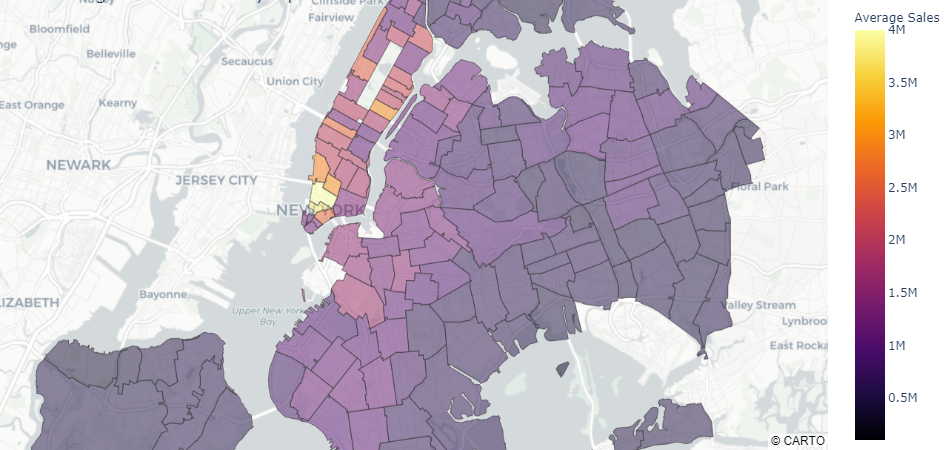

In [95]:
# Figure to show Sales/Rent and ROI Data

fig = px.choropleth_mapbox(df_new, geojson=counties, locations=df_new.index, color='Average Sales',
                           color_continuous_scale="inferno",featureidkey="properties.postalcode",
                           range_color=(100000, 4000000),
                           mapbox_style="carto-positron", 
                           zoom=10, center = {"lat": 40.7048, "lon": -73.9419},
                           opacity=0.5,
                           width = 800
                           ,hover_name = df_new.index
                           ,hover_data=df_new[["Average Sales", "Average Rent 2019", "ROI"]]
                           ,title="Average Sales in 2019 by Zip Code"
                           ,labels={'Average Sales 2019':'Average Sales 2019'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()
    

In [96]:
sales_grouped_date = sales_df.groupby(sales_df.index.year).mean()
sales_grouped_date

,Num of Units Sold,Average Sales,Median Sales
Date,,,
2015,24.049133,9.915098e+05,660365.120906
2016,23.056731,1.031253e+06,737353.441827
2017,22.725962,1.035852e+06,765641.041827
2018,18.692940,1.090809e+06,836714.370406
2019,16.743119,1.009635e+06,795491.393530


In [97]:
by_borough_2019 = sales_df[sales_df.index.year == 2019].groupby(['Neighborhood']).mean()
by_borough_2019.hvplot.bar(x='Neighborhood',y='Average Sales',rot=90).opts(height=500, width=900, title="Average Sales of 2019 by Neighborhood")


:Bars   [Neighborhood]   (Average Sales)

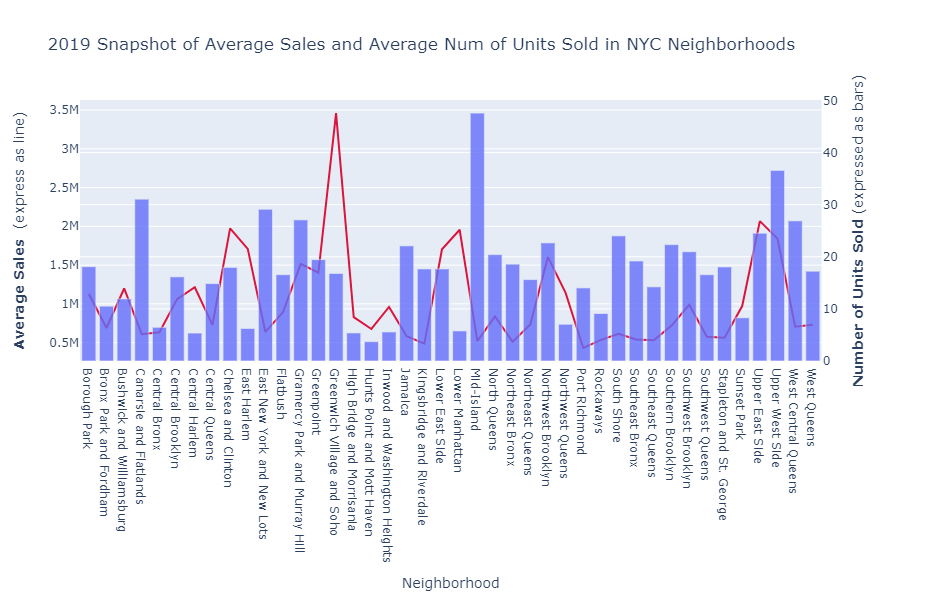

In [101]:
fig1 = px.line(by_borough_2019, x=by_borough_2019.index, y=by_borough_2019["Average Sales"])
fig1.update_traces(line_color='#DC143C')

fig2 = px.bar(by_borough_2019, x=by_borough_2019.index, y=by_borough_2019["Num of Units Sold"],opacity=0.8)

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    fig1.data[0],
    secondary_y=False,
)

fig.add_trace(
    fig2.data[0],
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="2019 Snapshot of Average Sales and Average Num of Units Sold in NYC Neighborhoods"
    , height=600
)

# Set x-axis title
fig.update_xaxes(title_text="Neighborhood")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Average Sales </b> (express as line)", secondary_y=False)
fig.update_yaxes(title_text="<b>Number of Units Sold</b> (expressed as bars)", secondary_y=True)

fig.show()

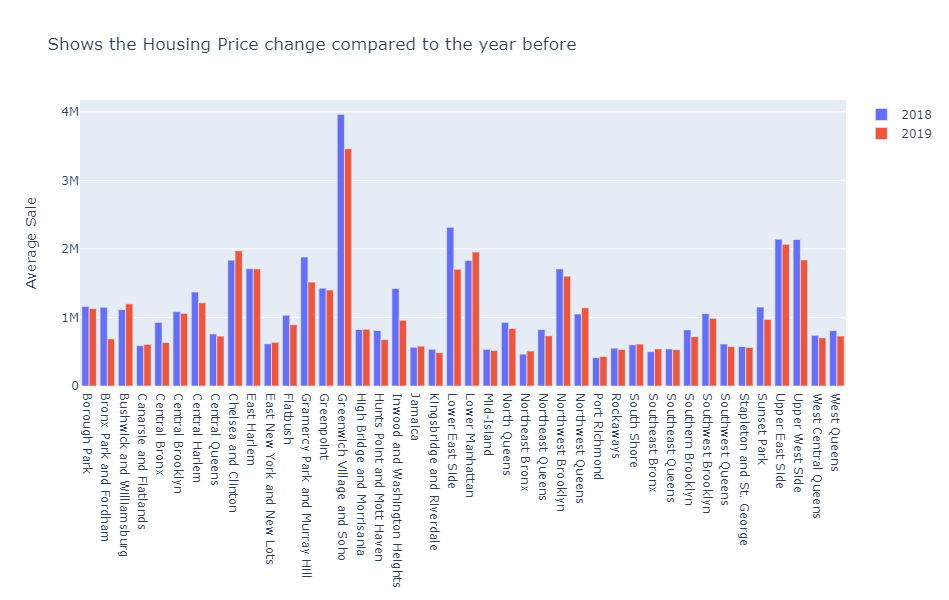

In [102]:
# compares two YoY changes for Average Sales 

by_borough_2018 = sales_df[sales_df.index.year == 2018].groupby(['Neighborhood']).mean()

fig = go.Figure(
    data=
    [
    go.Bar(name='2018', x=by_borough_2019.index, y=by_borough_2018['Average Sales']),
    go.Bar(name='2019', x=by_borough_2019.index, y=by_borough_2019['Average Sales'])    
],
    layout=go.Layout(
        title="Shows the Housing Price change compared to the year before",
        yaxis_title="Average Sale"
        ,height=600
    )
)

# Change the bar mode
fig.update_layout(barmode='group')
fig.show()